In [11]:
import os
import numpy as np
import h5py
import glob
import itertools
import sys
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim

from generatorIN import InEventLoader
import random
import time
print(sys.argv)
args_sumO = bool(int(sys.argv[3])) if len(sys.argv)>3 else False

['/home/anrunw/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py', '-f', '/home/anrunw/.local/share/jupyter/runtime/kernel-e615f19f-e202-471a-996b-772ad32eb045.json']


In [12]:

print(sys.argv)
args_sumO = bool(int(sys.argv[3])) if len(sys.argv)>3 else False
class GraphNet(nn.Module):
    def __init__(self, n_constituents, n_targets, params, hidden, De, Do, 
                 fr_activation=0, fo_activation=0, fc_activation=0, optimizer = 0, verbose = False):
        super(GraphNet, self).__init__()
        self.hidden = hidden
        self.P = len(params)
        self.N = n_constituents
        self.Nr = self.N * (self.N - 1)
        self.Dr = 0
        self.De = De
        self.Dx = 0
        self.Do = Do
        self.n_targets = n_targets
        self.fr_activation = fr_activation
        self.fo_activation = fo_activation
        self.fc_activation = fc_activation
        self.optimizer = optimizer
        self.verbose = verbose
        self.assign_matrices()

        self.sum_O = args_sumO
        self.Ra = torch.ones(self.Dr, self.Nr)
        self.fr1 = nn.Linear(2 * self.P + self.Dr, self.hidden)
        self.fr2 = nn.Linear(self.hidden, int(self.hidden/2))
        self.fr3 = nn.Linear(int(self.hidden/2), self.De)
        self.fo1 = nn.Linear(self.P + self.Dx + self.De, self.hidden)
        self.fo2 = nn.Linear(self.hidden, int(self.hidden/2))
        self.fo3 = nn.Linear(int(self.hidden/2), self.Do)
        if self.sum_O:
            self.fc1 = nn.Linear(self.Do *1, self.hidden)
        else:
            self.fc1 = nn.Linear(self.Do * self.N, self.hidden)
        self.fc2 = nn.Linear(self.hidden, int(self.hidden/2))
        self.fc3 = nn.Linear(int(self.hidden/2), self.n_targets)

    def assign_matrices(self):
        self.Rr = torch.zeros(self.N, self.Nr)
        self.Rs = torch.zeros(self.N, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.N)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            self.Rr[r, i] = 1
            self.Rs[s, i] = 1
        self.Rr = Variable(self.Rr)
        self.Rs = Variable(self.Rs)

    def forward(self, x):
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        if self.fr_activation ==2:
            B = nn.functional.selu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.selu(self.fr2(B))
            E = nn.functional.selu(self.fr3(B).view(-1, self.Nr, self.De))            
        elif self.fr_activation ==1:
            B = nn.functional.elu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.elu(self.fr2(B))
            E = nn.functional.elu(self.fr3(B).view(-1, self.Nr, self.De))
        else:
            B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
            B = nn.functional.relu(self.fr2(B))
            E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        C = torch.cat([x, Ebar], 1)
        del Ebar
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        if self.fo_activation ==2:
            C = nn.functional.selu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.selu(self.fo2(C))
            O = nn.functional.selu(self.fo3(C).view(-1, self.N, self.Do))
        elif self.fo_activation ==1:
            C = nn.functional.elu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.elu(self.fo2(C))
            O = nn.functional.elu(self.fo3(C).view(-1, self.N, self.Do))
        else:
            C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + self.De)))
            C = nn.functional.relu(self.fo2(C))
            O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        del C
        ## sum over the O matrix
        if self.sum_O:
            O = torch.sum( O, dim=1)
        ### Classification MLP ###
        if self.fc_activation ==2:
            if self.sum_O:
                N = nn.functional.selu(self.fc1(O.view(-1, self.Do * 1)))
            else:
                N = nn.functional.selu(self.fc1(O.view(-1, self.Do * self.N)))
            N = nn.functional.selu(self.fc2(N))       
        elif self.fc_activation ==1:
            if self.sum_O:
                N = nn.functional.elu(self.fc1(O.view(-1, self.Do * 1)))
            else:
                N = nn.functional.elu(self.fc1(O.view(-1, self.Do * self.N)))
            N = nn.functional.elu(self.fc2(N))
        else:
            if self.sum_O:
                N = nn.functional.relu(self.fc1(O.view(-1, self.Do * 1)))
            else:
                N = nn.functional.relu(self.fc1(O.view(-1, self.Do * self.N)))
            N = nn.functional.relu(self.fc2(N))
        del O
        #N = nn.functional.relu(self.fc3(N))
        N = self.fc3(N)
        return N

    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L 
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.reshape(-1, x_shape[2]), y).reshape(-1, x_shape[1], y_shape[1])

####################
    
def get_sample(training, target, choice):
    target_vals = np.argmax(target, axis = 1)
    ind, = np.where(target_vals == choice)
    chosen_ind = np.random.choice(ind, 50000)
    return training[chosen_ind], target[chosen_ind]

def accuracy(predict, target):
    _, p_vals = torch.max(predict, 1)
    r = torch.sum(target == p_vals.squeeze(1)).data.numpy()[0]
    t = target.size()[0]
    return r * 1.0 / t

def stats(predict, target):
    print(predict)
    _, p_vals = torch.max(predict, 1)
    t = target.cpu().data.numpy()
    p_vals = p_vals.squeeze(1).data.numpy()
    vals = np.unique(t)
    for i in vals:
        ind = np.where(t == i)
        pv = p_vals[ind]
        correct = sum(pv == t[ind])
        print("  Target %s: %s/%s = %s%%" % (i, correct, len(pv), correct * 100.0/len(pv)))
    print("Overall: %s/%s = %s%%" % (sum(p_vals == t), len(t), sum(p_vals == t) * 100.0/len(t)))
    return sum(p_vals == t) * 100.0/len(t)

best_perf = {
    30 : [50, 12,  6,  0,  2,  2,  0], #L 0.63
    50 : [50, 12, 14,  1,  2,  1,  0], #L 0.57
    100: [30, 10, 10,  1,  1,  1,  0], #L 0.56
    150: [10,  4, 14,  2,  2,  2,  0]  #L 0.62
}
sumO_best_perf = {
    30 : [ 6,  8,  6, 0, 1, 1, 0], #L 0.84
    50 : [50, 12, 14, 0, 0, 2, 0], #L 0.58
    100: [30,  4,  4, 2, 0, 2, 0], #L 0.62
    150: [50, 14, 10, 2, 2, 2, 0]  #L 0.55
}
# ### Prepare Dataset
nParticles = 30
x = sumO_best_perf[nParticles] if args_sumO else best_perf[nParticles]
#nParticles = 100
#x = []
#x.append(50) # hinned nodes
#x.append(12) # De
#x.append(4) # Do
#x.append(2) # fr_activation_index
#x.append(0) # fo_activation_index
#x.append(0) # fc_activation_index
#x.append(0) # optmizer_index

#####

['/home/anrunw/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py', '-f', '/home/anrunw/.local/share/jupyter/runtime/kernel-e615f19f-e202-471a-996b-772ad32eb045.json']


In [13]:
#####
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t']  # this is a classifier
params = ['j1_px', 'j1_py' , 'j1_pz' , 'j1_e' , 'j1_erel' , 'j1_pt' , 'j1_ptrel', 'j1_eta' , 'j1_etarel' , 
          'j1_etarot' , 'j1_phi' , 'j1_phirel' , 'j1_phirot', 'j1_deltaR' , 'j1_costheta' , 'j1_costhetarel'] # these are the features in the graph

val_split = 0.3
batch_size = 100
n_epochs = 20
patience = 10

In [14]:
nParticles = 30
import glob
#### LIST OF TRAINING FILES
inputTrainFiles = glob.glob("../data/train/5tag/jetImage*_%sp*.h5" %nParticles)
#### LIST OF VALIDATION FILES
inputValFiles = glob.glob("../data/val/5tag/jetImage*_%sp*.h5" %nParticles)
mymodel = GraphNet(nParticles, len(labels), params, int(x[0]), int(x[1]), int(x[2]), 
                   fr_activation=int(x[3]),  fo_activation=int(x[4]), fc_activation=int(x[5]), optimizer=int(x[6]), verbose=True)

In [15]:
inputValFiles

['../data/val/5tag/jetImage_7_30p_0_10000.h5']

In [21]:
loss = nn.CrossEntropyLoss(reduction='mean')
if mymodel.optimizer == 1:        
    optimizer = optim.Adadelta(mymodel.parameters(), lr = 0.0001)
else:
    optimizer = optim.Adam(mymodel.parameters(), lr = 0.0001)
loss_train = np.zeros(n_epochs)
loss_val = np.zeros(n_epochs)
nBatches_per_training_epoch = 49384/batch_size
nBatches_per_validation_epoch = 24693/batch_size
print("nBatches_per_training_epoch: %i" %nBatches_per_training_epoch)
print("nBatches_per_validation_epoch: %i" %nBatches_per_validation_epoch)

nBatches_per_training_epoch: 493
nBatches_per_validation_epoch: 246


In [22]:
mymodel.eval()

GraphNet(
  (fr1): Linear(in_features=32, out_features=50, bias=True)
  (fr2): Linear(in_features=50, out_features=25, bias=True)
  (fr3): Linear(in_features=25, out_features=12, bias=True)
  (fo1): Linear(in_features=28, out_features=50, bias=True)
  (fo2): Linear(in_features=50, out_features=25, bias=True)
  (fo3): Linear(in_features=25, out_features=6, bias=True)
  (fc1): Linear(in_features=180, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=5, bias=True)
)

In [ ]:
for i in range(n_epochs):
    start = time.time()
    if mymodel.verbose: print("Epoch %s" % i)
    # Define the data generators from the training set and validation set.
    random.shuffle(inputTrainFiles)
    random.shuffle(inputValFiles)
    train_set = InEventLoader(file_names=inputTrainFiles, nP=nParticles,
                              feature_name ='data',label_name = 'labels', verbose=False)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
    val_set = InEventLoader(file_names=inputValFiles, nP=nParticles,
                            feature_name ='data',label_name = 'labels', verbose=False)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    ####
    # train

    for batch_idx, mydict in enumerate(train_loader):
        data = mydict['jetConstituentList']
        target = mydict['jets']
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        out = mymodel(data)
        l = loss(out, target)
        l.backward()
        optimizer.step()
        loss_train[i] += l.cpu().data.numpy()/nBatches_per_training_epoch
    # validation

    for batch_idx, mydict in enumerate(val_loader):
        data = mydict['jetConstituentList']
        target = mydict['jets']
        data, target = Variable(data, volatile=True), Variable(target)
        out_val = mymodel(data)
        l_val = loss(out_val, target)
        loss_val[i] += l_val.cpu().data.numpy()/nBatches_per_validation_epoch

    if mymodel.verbose: print("Training   Loss: %f" %loss_train[i])
    if mymodel.verbose: print("Validation Loss: %f" %loss_val[i])
    if all(loss_val[max(0, i - patience):i] > min(np.append(loss_val[0:max(0, i - patience)], 200))) and i > patience:
        print("Early Stopping at",i)
        break
        #that above does not trigger soon enough        
    if i > (2*patience):
        last_avg = np.mean(loss_val[i - patience:i])
        previous_avg = np.mean(loss_val[i - 2*patience : i - patience])
        if last_avg > previous_avg:
            print("Early Avg Stopping at",i)
            break
    if i > patience:
        last_min = min(loss_val[i - patience:i])
        overall_min = min(loss_val[:i-patience])
        if last_min > overall_min:
            print("Early min Stopping at",i)
            break
    stop = time.time()
    duration = stop-start
    print('Time to Run Epoch: ' + str(duration))

Epoch 0


/home/anrunw/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Training   Loss: 4.371545
Validation Loss: 3.784645
Time to Run Epoch: 49.371970415115356
Epoch 1
Training   Loss: 2.485686
Validation Loss: 2.230590
Time to Run Epoch: 49.21049737930298
Epoch 2
Training   Loss: 1.193127
Validation Loss: 1.206673
Time to Run Epoch: 51.02082920074463
Epoch 3
Training   Loss: 1.176742
Validation Loss: 1.197220
Time to Run Epoch: 47.43619132041931
Epoch 4
Training   Loss: 1.159943
Validation Loss: 1.184952
Time to Run Epoch: 46.55116510391235
Epoch 5
Training   Loss: 1.143178
Validation Loss: 1.166453
Time to Run Epoch: 49.03259825706482
Epoch 6


In [14]:
import h5py,os
loc='IN_kFold_%s'%(sys.argv[1])
os.system('mkdir %s'%loc)
f = h5py.File("whydoirenamethis1.h5", "w")
f.create_dataset('train_loss', data= np.asarray(loss_train), compression='gzip')
f.create_dataset('val_loss', data= np.asarray(loss_val), compression='gzip')

# the best model
torch.save(mymodel.state_dict(), 'C:/Users/anrun/JEDInet-code/models/TrainedModel.params' )

OSError: Unable to create file (unable to truncate a file which is already open)

In [9]:
mymodel.load_state_dict(torch.load("../models/TrainedModel.params", map_location='cpu'))
mymodel.eval()

GraphNet(
  (fr1): Linear(in_features=32, out_features=50, bias=True)
  (fr2): Linear(in_features=50, out_features=25, bias=True)
  (fr3): Linear(in_features=25, out_features=12, bias=True)
  (fo1): Linear(in_features=28, out_features=50, bias=True)
  (fo2): Linear(in_features=50, out_features=25, bias=True)
  (fo3): Linear(in_features=25, out_features=6, bias=True)
  (fc1): Linear(in_features=180, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=5, bias=True)
)

In [ ]:
inputTestFiles = glob.glob("../data/test/5tag/jetImage*_%sp*.h5" %nParticles)


In [10]:
#read datasets
X = np.array([])                                                                                                                                      
Y = np.array([]) 
Y_hlf = np.array([]) 
for fileIN in inputTestFiles:
    if X.shape[0] >10000: continue
    f = h5py.File(fileIN, 'r')                                                                                                                        
    myFeatures = np.array(f.get('jetConstituentList'))                                                                                                
    myTarget = np.array(f.get('jets')[0:,-6:-1])
    myHLF = np.array(f.get('jets'))
    X = np.concatenate([X,myFeatures], axis = 0) if X.size else myFeatures                                                                            
    Y = np.concatenate([Y,myTarget], axis = 0) if Y.size else myTarget                                                                                
    Y_hlf = np.concatenate([Y_hlf,myHLF], axis = 0) if Y_hlf.size else myHLF                                                                                
    print(X.shape, Y.shape, Y_hlf.shape)

(10000, 30, 16) (10000, 5) (10000, 59)
(20000, 30, 16) (20000, 5) (20000, 59)


In [14]:
# pre-processing                                                                                                                                
X, Y, Y_hlf = shuffle(X, Y, Y_hlf, random_state=1)
X = np.swapaxes(X, 1, 2)
#Y = np.argmax(Y, axis=1)
X = torch.FloatTensor(X)
Y = torch.FloatTensor(Y)
Y_hlf = torch.FloatTensor(Y_hlf)

In [16]:
# extract the O matrix and the category output [TBF]
predict_test = []
lst = []
Otot = []
for j in torch.split(X, batch_size):
    a, myO = mymodel(j)
    a = a.cpu().data.numpy()
    myO = myO.cpu().data.numpy()
    # sum over particles
    lst.append(a)
    Otot.append(myO)
    
predicted = Variable(torch.FloatTensor(np.concatenate(lst)))
predicted = torch.nn.functional.softmax(predicted, dim=1)
predict_test = predicted.data.numpy()

O_predicted = Variable(torch.FloatTensor(np.concatenate(Otot)))
O_predicted_test = O_predicted.data.numpy()

RuntimeError: size mismatch, m1: [3000 x 16], m2: [30 x 870] at C:\cb\pytorch_1000000000000\work\aten\src\TH/generic/THTensorMath.cpp:41

In [ ]:
# ROC CURVE
import pandas as pd
from sklearn.metrics import roc_curve, auc
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(labels):
        df[label] = Y[:,i]
        df[label + '_pred'] = predict_test[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
        print('%s tagger, auc = %.1f%%' %(label,auc1[label]*100.))
        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%' %(label,auc1[label]*100.))
        plt.plot(tpr[label],fpr[label])
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='upper left')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))
plt.show()

In [17]:

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../python/sonic.mplstyle')

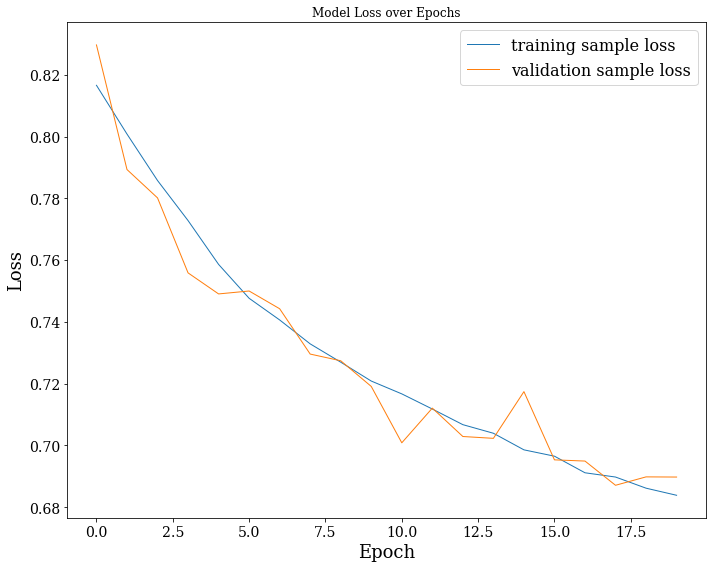

In [38]:
plt.figure(figsize=(10,8))
plt.plot(treeArray, linewidth=1)
plt.plot(treeArray2, linewidth=1)
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
#plt.savefig('Learning_curve.pdf')
plt.show()
plt.close()